In [208]:
import math
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import tree
from sklearn.metrics import precision_score
import random


%matplotlib inline
plt.rcParams.update({
        'font.size': 14,
        'axes.titlesize': 20,
        'axes.labelsize': 20,
        'xtick.labelsize': 20,
        'ytick.labelsize': 20,
        'font.size': 20,
        'figure.figsize': (10, 7),
        'axes.grid': True,
        'grid.linestyle': '-',
        'grid.alpha': 0.3,
        'lines.markersize': 5.0,
        'xtick.minor.visible': True,
        'xtick.direction': 'in',
        'xtick.major.size': 20.0,
        'xtick.minor.size': 10.0,
        'xtick.top': False,
        'xtick.bottom': True,
        'ytick.minor.visible': True,
        'ytick.direction': 'in',
        'ytick.major.size': 12.0,
        'ytick.minor.size': 6.0,
        'ytick.right': True,
        'errorbar.capsize': 0.0,
    })

# 1. Get the data

In [209]:
data = pd.read_csv('AB_Test_Results.csv')
data.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [210]:
data.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [211]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [214]:
data[['VARIANT_NAME', 'REVENUE']].groupby(by=['VARIANT_NAME'])\
    .agg(['mean', 'std', 'count'])

REVENUE                
                  mean       std count
VARIANT_NAME                          
control       0.129013  3.007524  4984
variant       0.070070  1.314802  5016

In [215]:
print(f"total users = {data['USER_ID'].count()}")
print(f"unique users = {data['USER_ID'].nunique()}")

total users = 10000
unique users = 6324


# 2. Data cleaning

## 2.1 Drop USER_IDs with two variants (control, variant)

In [216]:
# Drop users who are in both control and variant

# build Series with not duplicated users
not_duplicated = (data.groupby("USER_ID")["VARIANT_NAME"].nunique() == 1)
not_duplicated = not_duplicated[not_duplicated]

# select
data = data[data['USER_ID'].isin(not_duplicated.index)]

In [217]:
data.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
4,6174,variant,0.0
5,2380,variant,0.0
7,9168,control,0.0
9,7548,control,0.0
10,8395,control,0.0
11,1184,control,0.0
12,7165,control,0.0
14,3489,variant,0.0
16,7549,variant,0.0


In [218]:
data[['VARIANT_NAME', 'REVENUE']].groupby(by=['VARIANT_NAME'])\
    .agg(['mean', 'std', 'count'])

REVENUE                
                  mean       std count
VARIANT_NAME                          
control       0.155506  3.708620  3026
variant       0.058909  0.760344  3044

## 2.2 Look at extreme REVENUE values  

In [219]:
data.sort_values(by='REVENUE', ascending=False).head(10)

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
8168,2166,control,29.32
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47
5530,282,control,18.56
758,4445,control,17.05
4031,2059,control,14.24
9019,1973,control,14.07
4561,4966,variant,12.99


In [220]:
# Drop user with USER_ID = 3342
data[data['USER_ID'] == 3342]

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01


In [221]:
data = data[~(data['USER_ID'] == 3342)]

In [222]:
# A/B Groups & Target Summary Stats
data.groupby(by='VARIANT_NAME').agg({'USER_ID': 'nunique',
                                   'REVENUE': ['sum', 'mean', 'median', 'count']})

USER_ID REVENUE                       
             nunique     sum      mean median count
VARIANT_NAME                                       
control         2389  274.55  0.090760    0.0  3025
variant         2393  179.32  0.058909    0.0  3044

Control:
users paid = 53
total paid = 274.55
Variant:
users paid = 43
total paid = 179.32


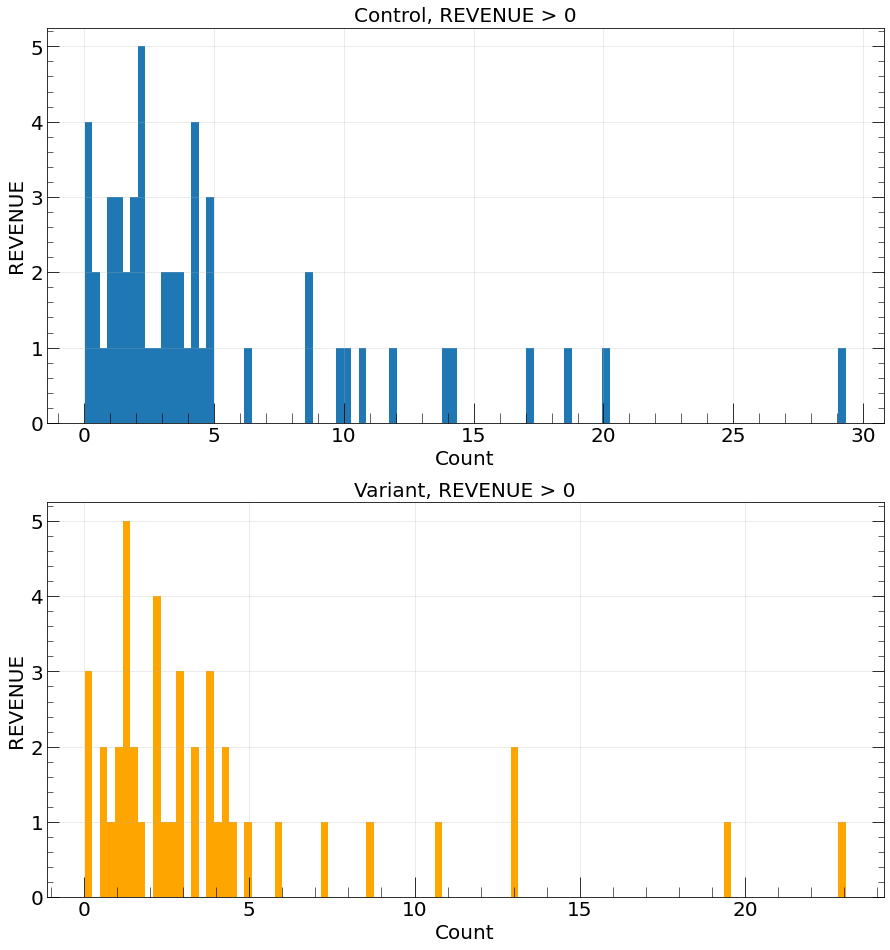

In [223]:
fig, ax = plt.subplots(2, 1, figsize=[15, 16])
data[data.VARIANT_NAME == 'control'].REVENUE.sort_values(
    ascending=False).head(10)

print("Control:")
print(
    f"users paid = {data[(data.VARIANT_NAME == 'control') & (data['REVENUE'] > 0)].agg({'REVENUE': 'count'})[0]}"
)
print(
    f"total paid = {data[(data.VARIANT_NAME == 'control') & (data['REVENUE'] > 0)].agg({'REVENUE': 'sum'})[0]}"
)

revnue_control_cuted = data[(data.VARIANT_NAME == 'control')
                            & (data['REVENUE'] > 0)].REVENUE

ax[0].hist(revnue_control_cuted, bins=100)
ax[0].set_title('Control, REVENUE > 0')
ax[0].set_xlabel('Count')
ax[0].set_ylabel('REVENUE')

print("Variant:")
print(
    f"users paid = {data[(data.VARIANT_NAME == 'variant') & (data['REVENUE'] > 0)].agg({'REVENUE': 'count'})[0]}"
)
print(
    f"total paid = {data[(data.VARIANT_NAME == 'variant') & (data['REVENUE'] > 0)].agg({'REVENUE': 'sum'})[0]}"
)

revnue_variant_cuted = data[(data.VARIANT_NAME == 'variant')
                            & (data['REVENUE'] > 0)].REVENUE

ax[1].hist(revnue_variant_cuted, bins=100, color='orange')
ax[1].set_title('Variant, REVENUE > 0')
ax[1].set_xlabel('Count')
ax[1].set_ylabel('REVENUE')

plt.show()

## 2.3 Discard users which have multiple inputs

In [224]:
# We get only users with unique USER_ID (and unique VARIANT NAME)

data = data.groupby(by=['USER_ID', 'VARIANT_NAME']).sum().reset_index()

In [225]:
data[['VARIANT_NAME', 'REVENUE']].groupby(by=['VARIANT_NAME'])\
    .agg(['mean', 'std', 'count'])

REVENUE                
                  mean       std count
VARIANT_NAME                          
control       0.114923  1.162495  2389
variant       0.074935  0.858207  2393

# 3. Statistical analysis

## 3.1 Cheking if distribution is normal

From histograms we seen that data are not normaly distributed, check it with Shapiro-Wilks test <br>
https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test

In [226]:
print('Shapiro-Wilks test for control sample')
print(70*'-')
print('All users')
display(stats.shapiro(data[data['VARIANT_NAME'] == 'control']['REVENUE']))
print('Users with REVENUE > 0')
display(stats.shapiro(data[(data['VARIANT_NAME'] == 'control') & (data['REVENUE'] > 0)]['REVENUE']))

Shapiro-Wilks test for control sample
----------------------------------------------------------------------
All users


ShapiroResult(statistic=0.07461178302764893, pvalue=0.0)

Users with REVENUE > 0


ShapiroResult(statistic=0.7512773871421814, pvalue=4.1299607289602136e-08)

In [227]:
print('Shapiro-Wilks test for variant sample')
print(70*'-')
print('All users')
display(stats.shapiro(data[data['VARIANT_NAME'] == 'variant']['REVENUE']))
print('Users with REVENUE > 0')
display(stats.shapiro(data[(data['VARIANT_NAME'] == 'variant') & (data['REVENUE'] > 0)]['REVENUE']))

Shapiro-Wilks test for variant sample
----------------------------------------------------------------------
All users


ShapiroResult(statistic=0.06145977973937988, pvalue=0.0)

Users with REVENUE > 0


ShapiroResult(statistic=0.713570773601532, pvalue=9.888944418889878e-08)

Due to results of Shapiro-Wilks test we reject H0 that distribution are normal

## 3.2 Mann-Whitney test (distributions are independent)

We use Mann-Whitney U test to compare two distributions because they are not normal (requirement to meet for t-test)

https://ru.wikipedia.org/wiki/U-%D0%BA%D1%80%D0%B8%D1%82%D0%B5%D1%80%D0%B8%D0%B9_%D0%9C%D0%B0%D0%BD%D0%BD%D0%B0_%E2%80%94_%D0%A3%D0%B8%D1%82%D0%BD%D0%B8

Null hypothesis (H0): The two groups are sampled from populations with identical distributions.  Typically, the sampled populations exhibit stochastic equality

Alternative hypothesis (H1: The two groups are sampled from populations with different distributions (see the previous section).  Most of the time, this means that one of the sampled populations (groups) displays stochastic dominance.

In [228]:
# First chek distribution including REVENUE = 0

stats.mannwhitneyu(data.loc[data['VARIANT_NAME'] == 'variant', 'REVENUE'],
                   data.loc[data['VARIANT_NAME'] == 'control', 'REVENUE'])

MannwhitneyuResult(statistic=2845109.0, pvalue=0.12399777553410979)

In [230]:
# Only uses with REVENUE > 0

stats.mannwhitneyu(data.loc[(data['VARIANT_NAME'] == 'variant') & (data['REVENUE'] > 0), 'REVENUE'],
                   data.loc[(data['VARIANT_NAME'] == 'control') & (data['REVENUE'] > 0), 'REVENUE'])

MannwhitneyuResult(statistic=1029.0, pvalue=0.2657096108542354)

We confirm H0 that distributions are the same due to hight p-value = 0.266

## 3.3 t-test

Just for reference, don't rely on this result

In [231]:
mean_variant = data[['VARIANT_NAME', 'REVENUE']].groupby(['VARIANT_NAME'])\
    .agg('mean').loc['variant'][0]
mean_control = data[['VARIANT_NAME', 'REVENUE']].groupby(['VARIANT_NAME'])\
    .agg('mean').loc['control'][0]

std_variant = data[['VARIANT_NAME', 'REVENUE']].groupby(['VARIANT_NAME'])\
    .agg('std').loc['variant'][0]

std_control = data[['VARIANT_NAME', 'REVENUE']].groupby(['VARIANT_NAME'])\
    .agg('std').loc['control'][0]

n_variant = data[['VARIANT_NAME', 'REVENUE']].groupby(['VARIANT_NAME'])\
    .agg('count').loc['variant'][0]

n_control = data[['VARIANT_NAME', 'REVENUE']].groupby(['VARIANT_NAME'])\
    .agg('count').loc['control'][0]

delta = mean_variant - mean_control
sigma_variant = std_variant / np.sqrt(n_variant)
sigma_control = std_control / np.sqrt(n_control)
t = abs(delta / np.sqrt(sigma_variant**2 + sigma_control**2))

ndf = data.shape[0] - 2

p_value = 2 * (1 - stats.t(df=ndf).cdf(t))
p_value = 2 * stats.t(df=ndf).sf(t)

print(f"variant = {round(mean_variant, 3)} +/- {round(sigma_variant, 3)}")
print(f"control = {round(mean_control, 3)} +/- {round(sigma_control, 3)}")
print(f"delta = {round(delta, 5)}")
print(f"t = {round(t, 5)}")
print(f"NDF = {ndf}")
print(f"p-value = {p_value}")

variant = 0.075 +/- 0.018
control = 0.115 +/- 0.024
delta = -0.03999
t = 1.35301
NDF = 4780
p-value = 0.17611509437414055


## 3.4 Bootstrap

In [238]:
test_data = data.loc[data.VARIANT_NAME == 'control', 'REVENUE'].values
test_data

array([0., 0., 0., ..., 0., 0., 0.])

In [237]:
np.random.randint(0, len(test_data), (1000, len(test_data)))

array([[1017,  199,  733, ...,  588, 1836,   77],
       [ 646,  873, 1839, ...,  391, 2080, 1346],
       [1628, 1565, 1689, ..., 1496, 1726, 2217],
       ...,
       [1799, 2226, 1594, ..., 1159, 1396, 1280],
       [ 895, 1649, 1089, ..., 1783, 1973, 1322],
       [ 795,  442, 2042, ..., 1318, 1327,  882]])

In [239]:
def get_bootstrap_samples(data, n_samples=1000):
    # create numpy array with shape (n_samples, len(data)) with indices of rows
    indices = np.random.randint(0, len(data), size=(n_samples, len(data)))
    samples = data[indices]
    print(f"shape = {samples.shape}")
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [245]:
# samples for all users

control_samples = get_bootstrap_samples(data.loc[data.VARIANT_NAME == 'control', 'REVENUE'].values, 10000)
variant_samples = get_bootstrap_samples(data.loc[data.VARIANT_NAME == 'variant', 'REVENUE'].values, 10000)

shape = (10000, 2389)
shape = (10000, 2393)


In [246]:
# samples only for paying users (REVENUE > 0)

control_samples_paid = get_bootstrap_samples(data.loc[(data.VARIANT_NAME == 'control') & (data['REVENUE'] > 0), 'REVENUE'].values, 10000)
variant_samples_paid = get_bootstrap_samples(data.loc[(data.VARIANT_NAME == 'variant') & (data['REVENUE'] > 0), 'REVENUE'].values, 10000)

shape = (10000, 53)
shape = (10000, 42)


Text(0.5, 1.0, 'Sample mean distribution for all users')

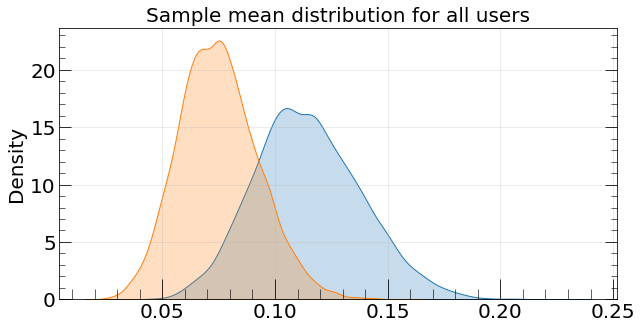

In [248]:
# Take a look on the distribution of means of these samples

fig, ax = plt.subplots(figsize=(10,5))
sns.kdeplot(np.mean(control_samples, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant_samples, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for all users')

Text(0.5, 1.0, 'Sample mean distribution for paying users')

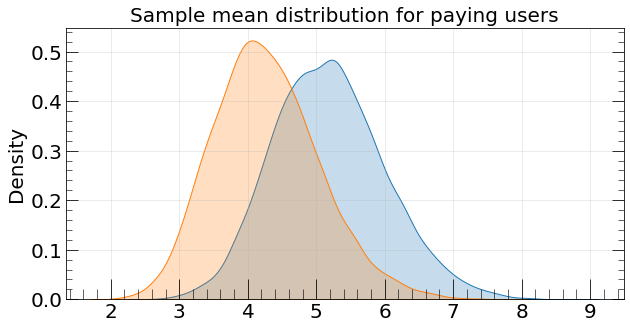

In [249]:
fig, ax = plt.subplots(figsize=(10,5))
sns.kdeplot(np.mean(control_samples_paid, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant_samples_paid, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for paying users')

We can see the difference between distributions means but there are strong overlap